In [11]:
import scipy.io as sio
import numpy as np
import cv2
import copy
import sys
from utils import gauss_normal_generate, cvt2HeatmapImg
from utils import cvt2HeatmapMatrix, point_generate, interval_list_generate
import torch.utils.data as data
import torch
import random
from utils import interval_list_generate
import matplotlib.pyplot as plt

class SynthText(object):
    def __init__(self):
        self.generate_information()
        
    def generate_information(self):
        self.data = sio.loadmat('/data/data/synthtext/SynthText/gt.mat')
        char_BB = self.data['charBB']
        self.cor_list = char_BB[0]
        img_txt = self.data['txt']
        self.text = img_txt[0]
        names = self.data['imnames']
        # the third 0 to get the string in list
        self.name = names[0]
        self.gauss_map = gauss_normal_generate(20)

    def len(self):
        return len(self.data['charBB'][0])

    def im_read_resize(self, path):
        img = cv2.imread(path)
        img_size = (img.shape[0], img.shape[1])
        if img_size[0] > img_size[1]:
            img = np.rot90(img, -1)
        resized_img = cv2.resize(img, (600, 400), cv2.INTER_NEAREST)
        return resized_img, img_size

    def char_label_generate(self, gauss_map, img_size, cor_list):
        # generate the first map with all char box being replaced with gauss map
        h = img_size[0]
        w = img_size[1]
        char_label = np.zeros((h, w))
        char_number = cor_list.shape[2]
        for i in range(char_number):
            x = []
            y = []
            for index in range(4):
                x.append(copy.deepcopy(int(cor_list[0][index][i])))
                y.append(copy.deepcopy(int(cor_list[1][index][i])))
            x_min = max(min(x), 0)
            x_max = min(max(x), w)
            y_min = max(min(y), 0)
            y_max = min(max(y), h)
            point1 = np.array([[0, 0], [19, 0], [19, 19], [0, 19]], dtype='float32')
            point2 = np.array([[x[0]-x_min, y[0]-y_min], [x[1]-x_min, y[1]-y_min],
                            [x[2]-x_min, y[2]-y_min], [x[3]-x_min, y[3]-y_min]], dtype='float32')
            w_final = x_max - x_min
            h_final = y_max - y_min
            m = cv2.getPerspectiveTransform(point1, point2)
            target = cv2.warpPerspective(gauss_map, m, (w_final, h_final), cv2.INTER_NEAREST)
            for j in range(y_min, y_max):
                for k in range(x_min, x_max):
                    if target[j-y_min][k-x_min] > char_label[j][k]:
                        char_label[j, k] = target[j-y_min][k-x_min]
        if h > w:
            char_label = np.rot90(char_label, -1)
        char_label = cv2.resize(char_label, (300, 200), cv2.INTER_NEAREST)
        char_label = cvt2HeatmapMatrix(char_label)
        return char_label
    
    def interval_label_generate(self, gauss_map, img_size, cor_list, interval_list):
        # generate the first map with all char box being replaced with gauss map
        h = img_size[0]
        w = img_size[1]
        interval_label = np.zeros((h, w))
        char_number = cor_list.shape[2]
        for i in range(char_number-1):
            if i+1 in interval_list:
                continue
            x1 = []
            y1 = []
            x2 = []
            y2 = []
            for index in range(4):
                x1.append(copy.deepcopy(int(cor_list[0][index][i])))
                y1.append(copy.deepcopy(int(cor_list[1][index][i])))
                x2.append(copy.deepcopy(int(cor_list[0][index][i+1])))
                y2.append(copy.deepcopy(int(cor_list[1][index][i+1])))
            x, y = point_generate(x1, y1, x2, y2)
            x_min = max(min(x), 0)
            x_max = min(max(x), w)
            y_min = max(min(y), 0)
            y_max = min(max(y), h)
            point1 = np.array([[0, 0], [19, 0], [19, 19], [0, 19]], dtype='float32')
            point2 = np.array([[x[0]-x_min, y[0]-y_min], [x[1]-x_min, y[1]-y_min],
                            [x[2]-x_min, y[2]-y_min], [x[3]-x_min, y[3]-y_min]], dtype='float32')
            w_final = x_max - x_min
            h_final = y_max - y_min
            m = cv2.getPerspectiveTransform(point1, point2)
            target = cv2.warpPerspective(gauss_map, m, (w_final, h_final), cv2.INTER_NEAREST)
            for j in range(y_min, y_max):
                for k in range(x_min, x_max):
                    if target[j-y_min][k-x_min] > interval_label[j][k]:
                        interval_label[j, k] = target[j-y_min][k-x_min]
        if h > w:
            interval_label = np.rot90(interval_label, -1)        
        interval_label = cv2.resize(interval_label, (300, 200), cv2.INTER_NEAREST)
        interval_label = cvt2HeatmapMatrix(interval_label)
        return interval_label


    
    
    
    
    
    
    
    
    
    
    
    

class ImageLoader_synthtext(data.Dataset):
    def __init__(self):
        self.img_rootdir = "/data/data/synthtext/SynthText/"
        self.dataset = SynthText()
    def __len__(self):
        return self.dataset.len()
    def __getitem__(self, index):
        img_path = self.img_rootdir + self.dataset.name[index][0]
        ori_img = resized_img = cv2.resize(cv2.imread(img_path), (600, 400), cv2.INTER_NEAREST)
        
        img, img_size = self.dataset.im_read_resize(img_path)
        char_label = self.dataset.char_label_generate(self.dataset.gauss_map, img_size, self.dataset.cor_list[index])
        interval_list = interval_list_generate(self.dataset.text[index])
        interval_label = self.dataset.interval_label_generate(self.dataset.gauss_map, img_size, self.dataset.cor_list[index], interval_list)
#         img, char_label, interval_label = random_augmentation(img, char_label, interval_label)
        
#         image = torch.from_numpy(image).float().permute(2, 0, 1)
        
        img = torch.Tensor(img)
        char_label = torch.Tensor(char_label)
        interval_label = torch.Tensor(interval_label)
        return img, char_label, interval_label,ori_img

def collate(batch):
    imgs = []
    char_labels = []
    interval_labels = []
    for sample in batch:
        imgs.append(sample[0])
        char_labels.append(sample[1])
        interval_labels.append(sample[2])
    imgs_stack = torch.stack(imgs, 0)
    char_labels_stack = torch.stack(char_labels, 0)
    interval_labels_stack = torch.stack(interval_labels, 0)
    return imgs_stack.permute(0,3,1,2), char_labels_stack, interval_labels_stack

def random_augmentation(image, char_label, interval_label):
    f = ImageTransfer(image, char_label, interval_label)
    seed = random.randint(0, 5)  # 0: original image used
    if 0 < seed < 5:
        methods = ['rotate', 'add_noise', 'change_contrast', 'change_hsv']
#         methods = ['rotate', 'add_noise', 'change_contrast', 'change_hsv']
        image, char_label, interval_label = getattr(f, methods[seed-1])()
    return image, char_label, interval_label

class ImageTransfer(object):
    """add noise, rotate, change contrast, change_hsv"""
    def __init__(self, image, char_label, interval_label):
        """image: a ndarray with size [h, w, 3]"""
        """label: a ndarray with size [h/2, w/2]"""
        self.image = image
        self.char_label = char_label
        self.interval_label = interval_label

    def add_noise(self):
        img = self.image * (np.random.rand(*self.image.shape) * 0.4 + 0.6)
        img = img.astype(np.uint8)
        char_label = self.char_label
        interval_label = self.interval_label
        return img, char_label, interval_label

    def rotate(self, angle=None, center=None, scale=1.0, angle_min=20, angle_max=180):
        h, w = self.image.shape[:2]
        h1, w1 = self.char_label.shape
        if angle is None:
            angle = random.randint(angle_min, angle_max) if random.random() < 0.5 else random.randint(-angle_max, -angle_min)
        if center is None:
            center = (w // 2, h // 2)
            center1 = (w1 // 2, h1 // 2)
        M = cv2.getRotationMatrix2D(center, angle, scale)
        M1 = cv2.getRotationMatrix2D(center1, angle, scale)
        return cv2.warpAffine(self.image, M, (w, h)), cv2.warpAffine(self.char_label, M1, (w1, h1)), cv2.warpAffine(self.interval_label, M1, (w1, h1))

    def change_contrast(self):
        if random.random() < 0.5:
            k = random.randint(5, 9) / 10.0
        else:
            k = random.randint(11, 15) / 10.0
        b = 128 * (k - 1)
        img = self.image.astype(np.float)
        img = k * img - b
        img = np.maximum(img, 0)
        img = np.minimum(img, 255)
        img = img.astype(np.uint8)
        char_label = self.char_label
        interval_label = self.interval_label
        return img, char_label, interval_label

    def change_hsv(self):
        img = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        char_label = self.char_label
        interval_label = self.interval_label
        s = random.random()
        def ch_h():
            dh = random.randint(2, 10) * random.randrange(-1,2,2)
            img[:, :, 0] = (img[:,:,0] + dh) % 180
        def ch_s():
            ds = random.random() * 0.25 + 0.7
            img[:, :, 1] = ds * img[:, :, 1]
        def ch_v():
            dv = random.random() * 0.35 + 0.6
            img[:, :, 2] = dv * img[:, :, 2]
        if s < 0.25:
            ch_h()
        elif s < 0.50:
            ch_s()
        elif s < 0.75:
            ch_v()
        else:
            ch_h()
            ch_s()
            ch_v()
        return cv2.cvtColor(img, cv2.COLOR_HSV2BGR), char_label, interval_label

    
    
    
    
    
    
    
    

In [12]:
dataset = ImageLoader_synthtext()

# data_loader = data.DataLoader(dataset, args.batch_size, num_workers=0, shuffle=True, collate_fn=collate)

In [14]:
img, char_label, interval_label,ori_img = dataset.__getitem__(122)

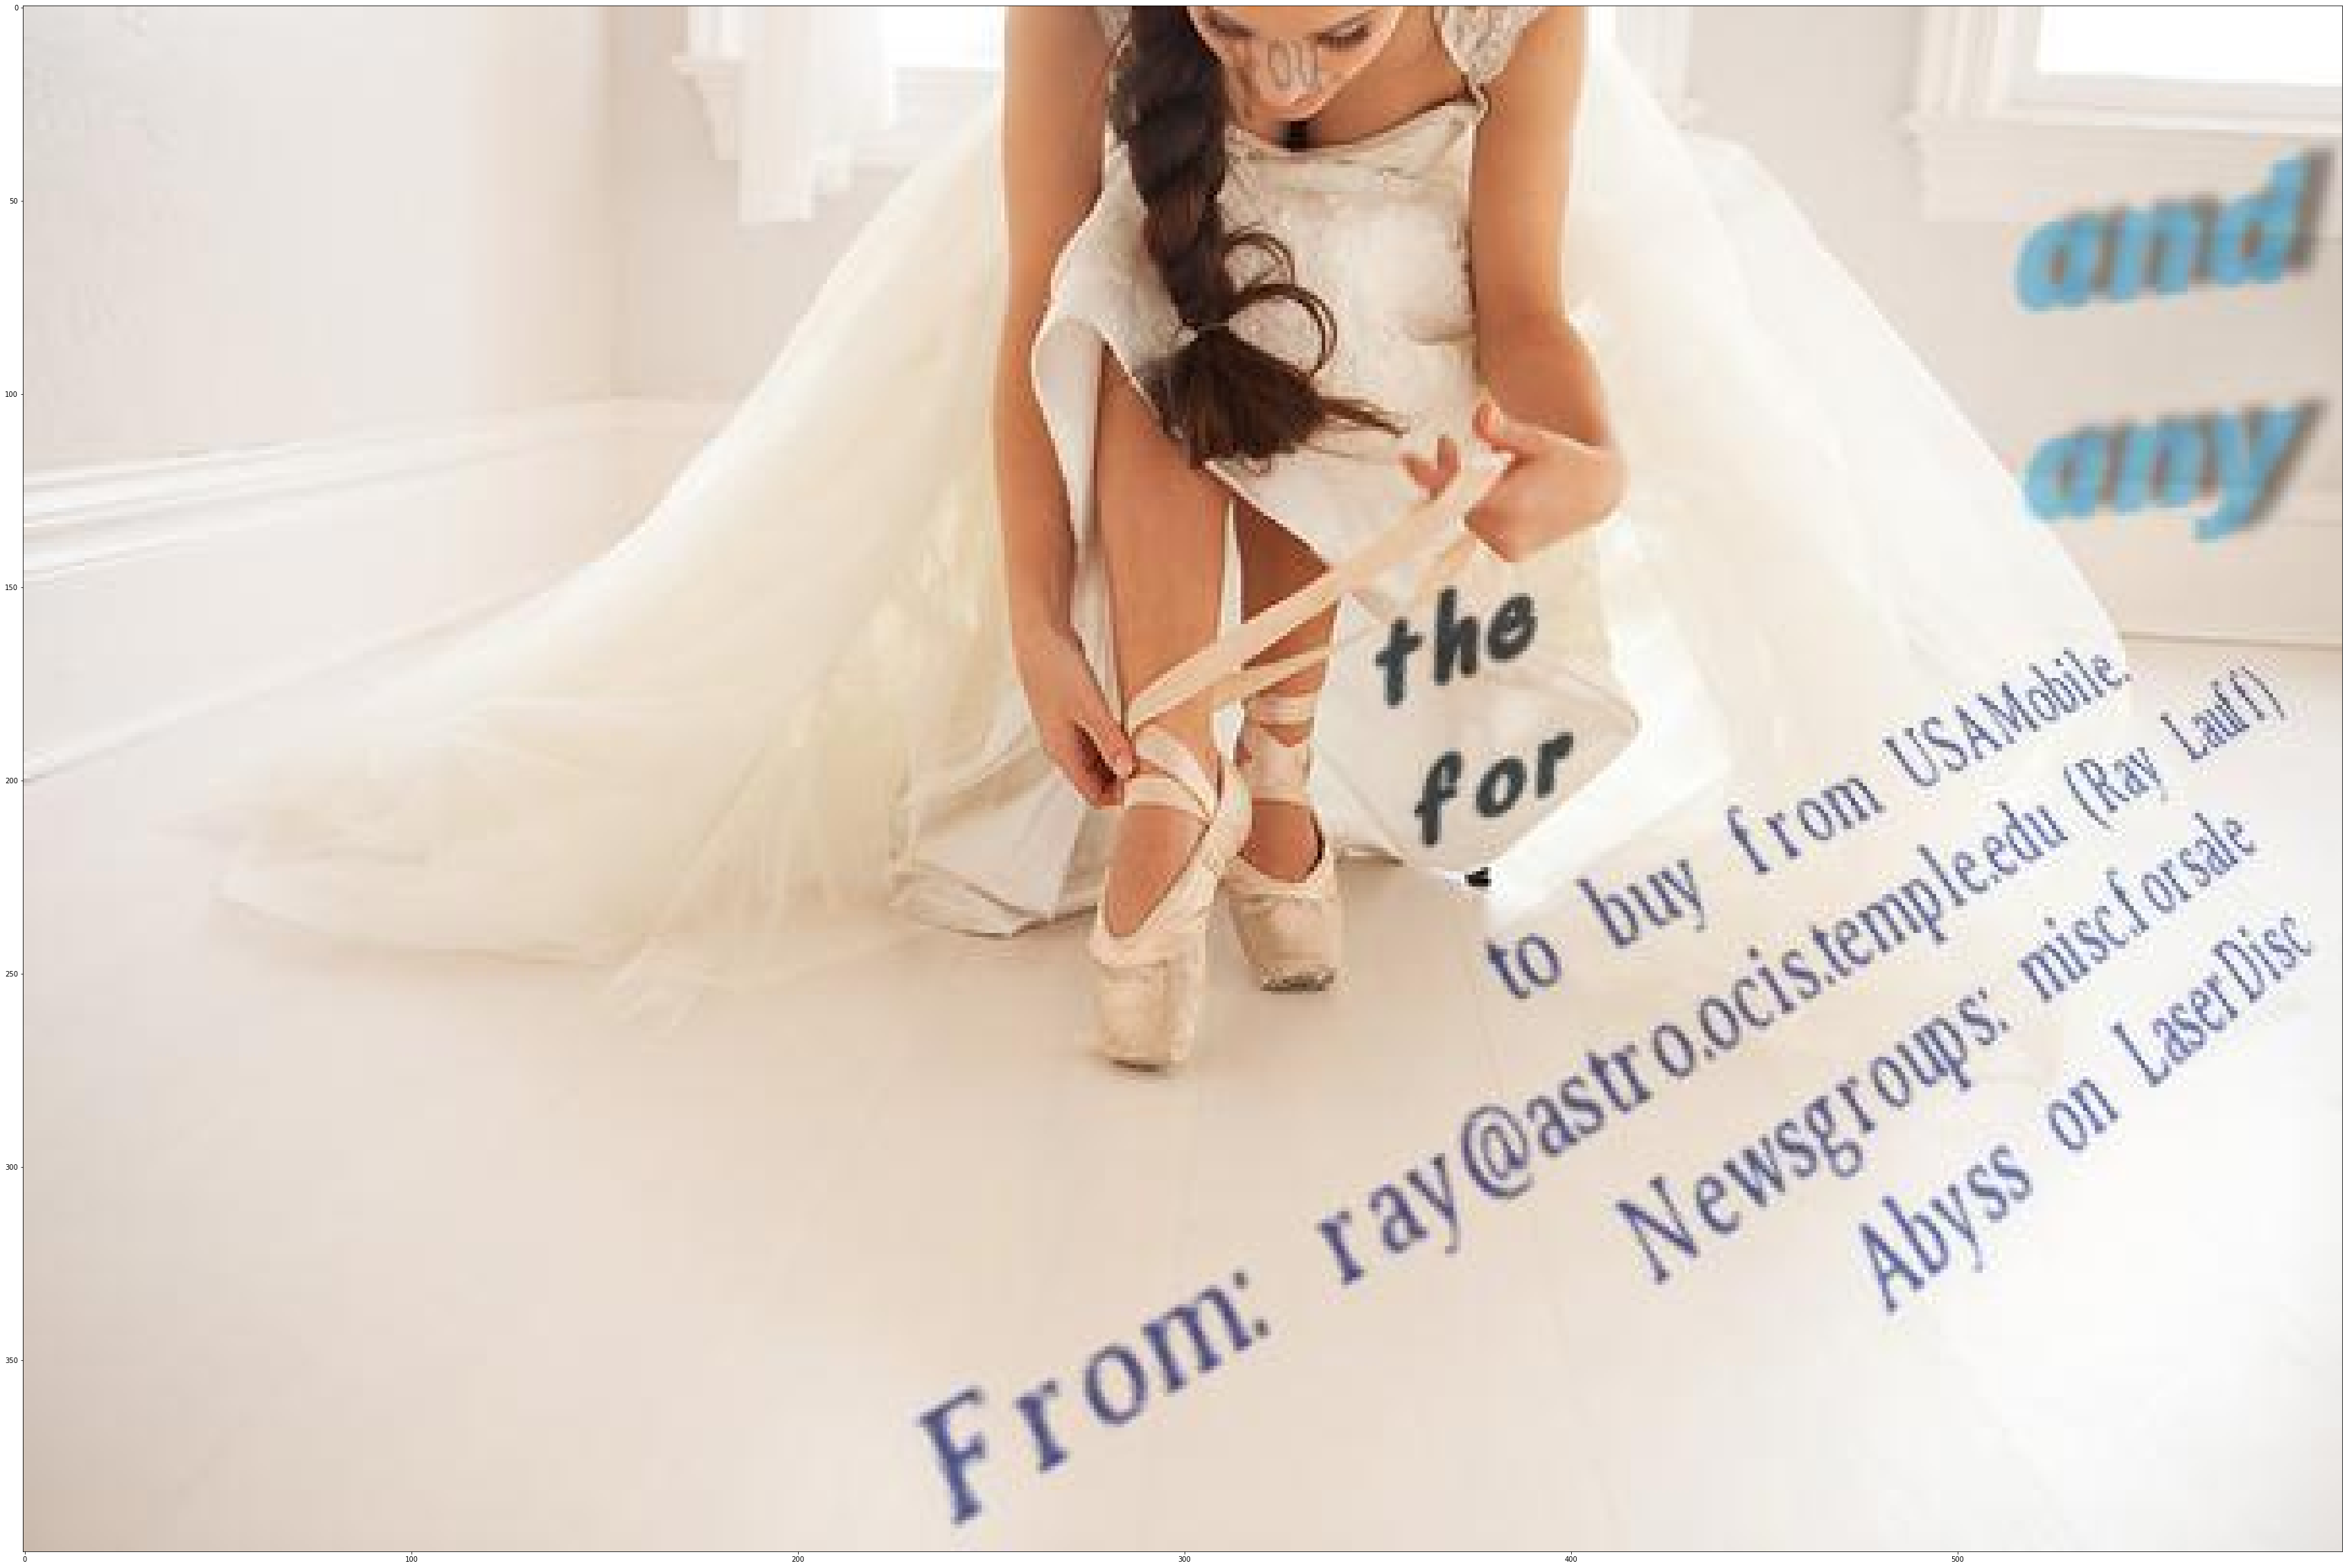

In [19]:
img_data = ori_img
plt.figure(figsize = (60,60))

## rgb = bgr[...,::-1].copy()
plt.imshow(img_data[...,::-1])

In [ ]:
print(img_data.numpy().shape)
print(img_data.numpy())

In [7]:
## mat파일은 3가지 컬럼으로 구성
# charBB
# txt
# imnames


temp = sio.loadmat('/data/data/synthtext/SynthText/gt.mat')
## 불러온 자료형태는 dict형
print(len(temp))
print(type(temp))


In [41]:
print(temp.keys())

dict_keys(['__header__', '__version__', '__globals__', 'charBB', 'wordBB', 'imnames', 'txt'])


In [43]:
print(len(temp['charBB']))
print(type(temp['charBB']))
print(temp['charBB'].shape)
print(len(temp['charBB'][0]),type(temp['charBB'][0]))


print(temp['charBB'][0].shape)
print(temp['charBB'][0][0].shape)
print(temp['imnames'][0][0])

1
<class 'numpy.ndarray'>
(1, 858750)
858750 <class 'numpy.ndarray'>
(858750,)
(2, 4, 54)
['8/ballet_106_0.jpg']


/data/data/synthtext/SynthText/8/ballet_106_0.jpg


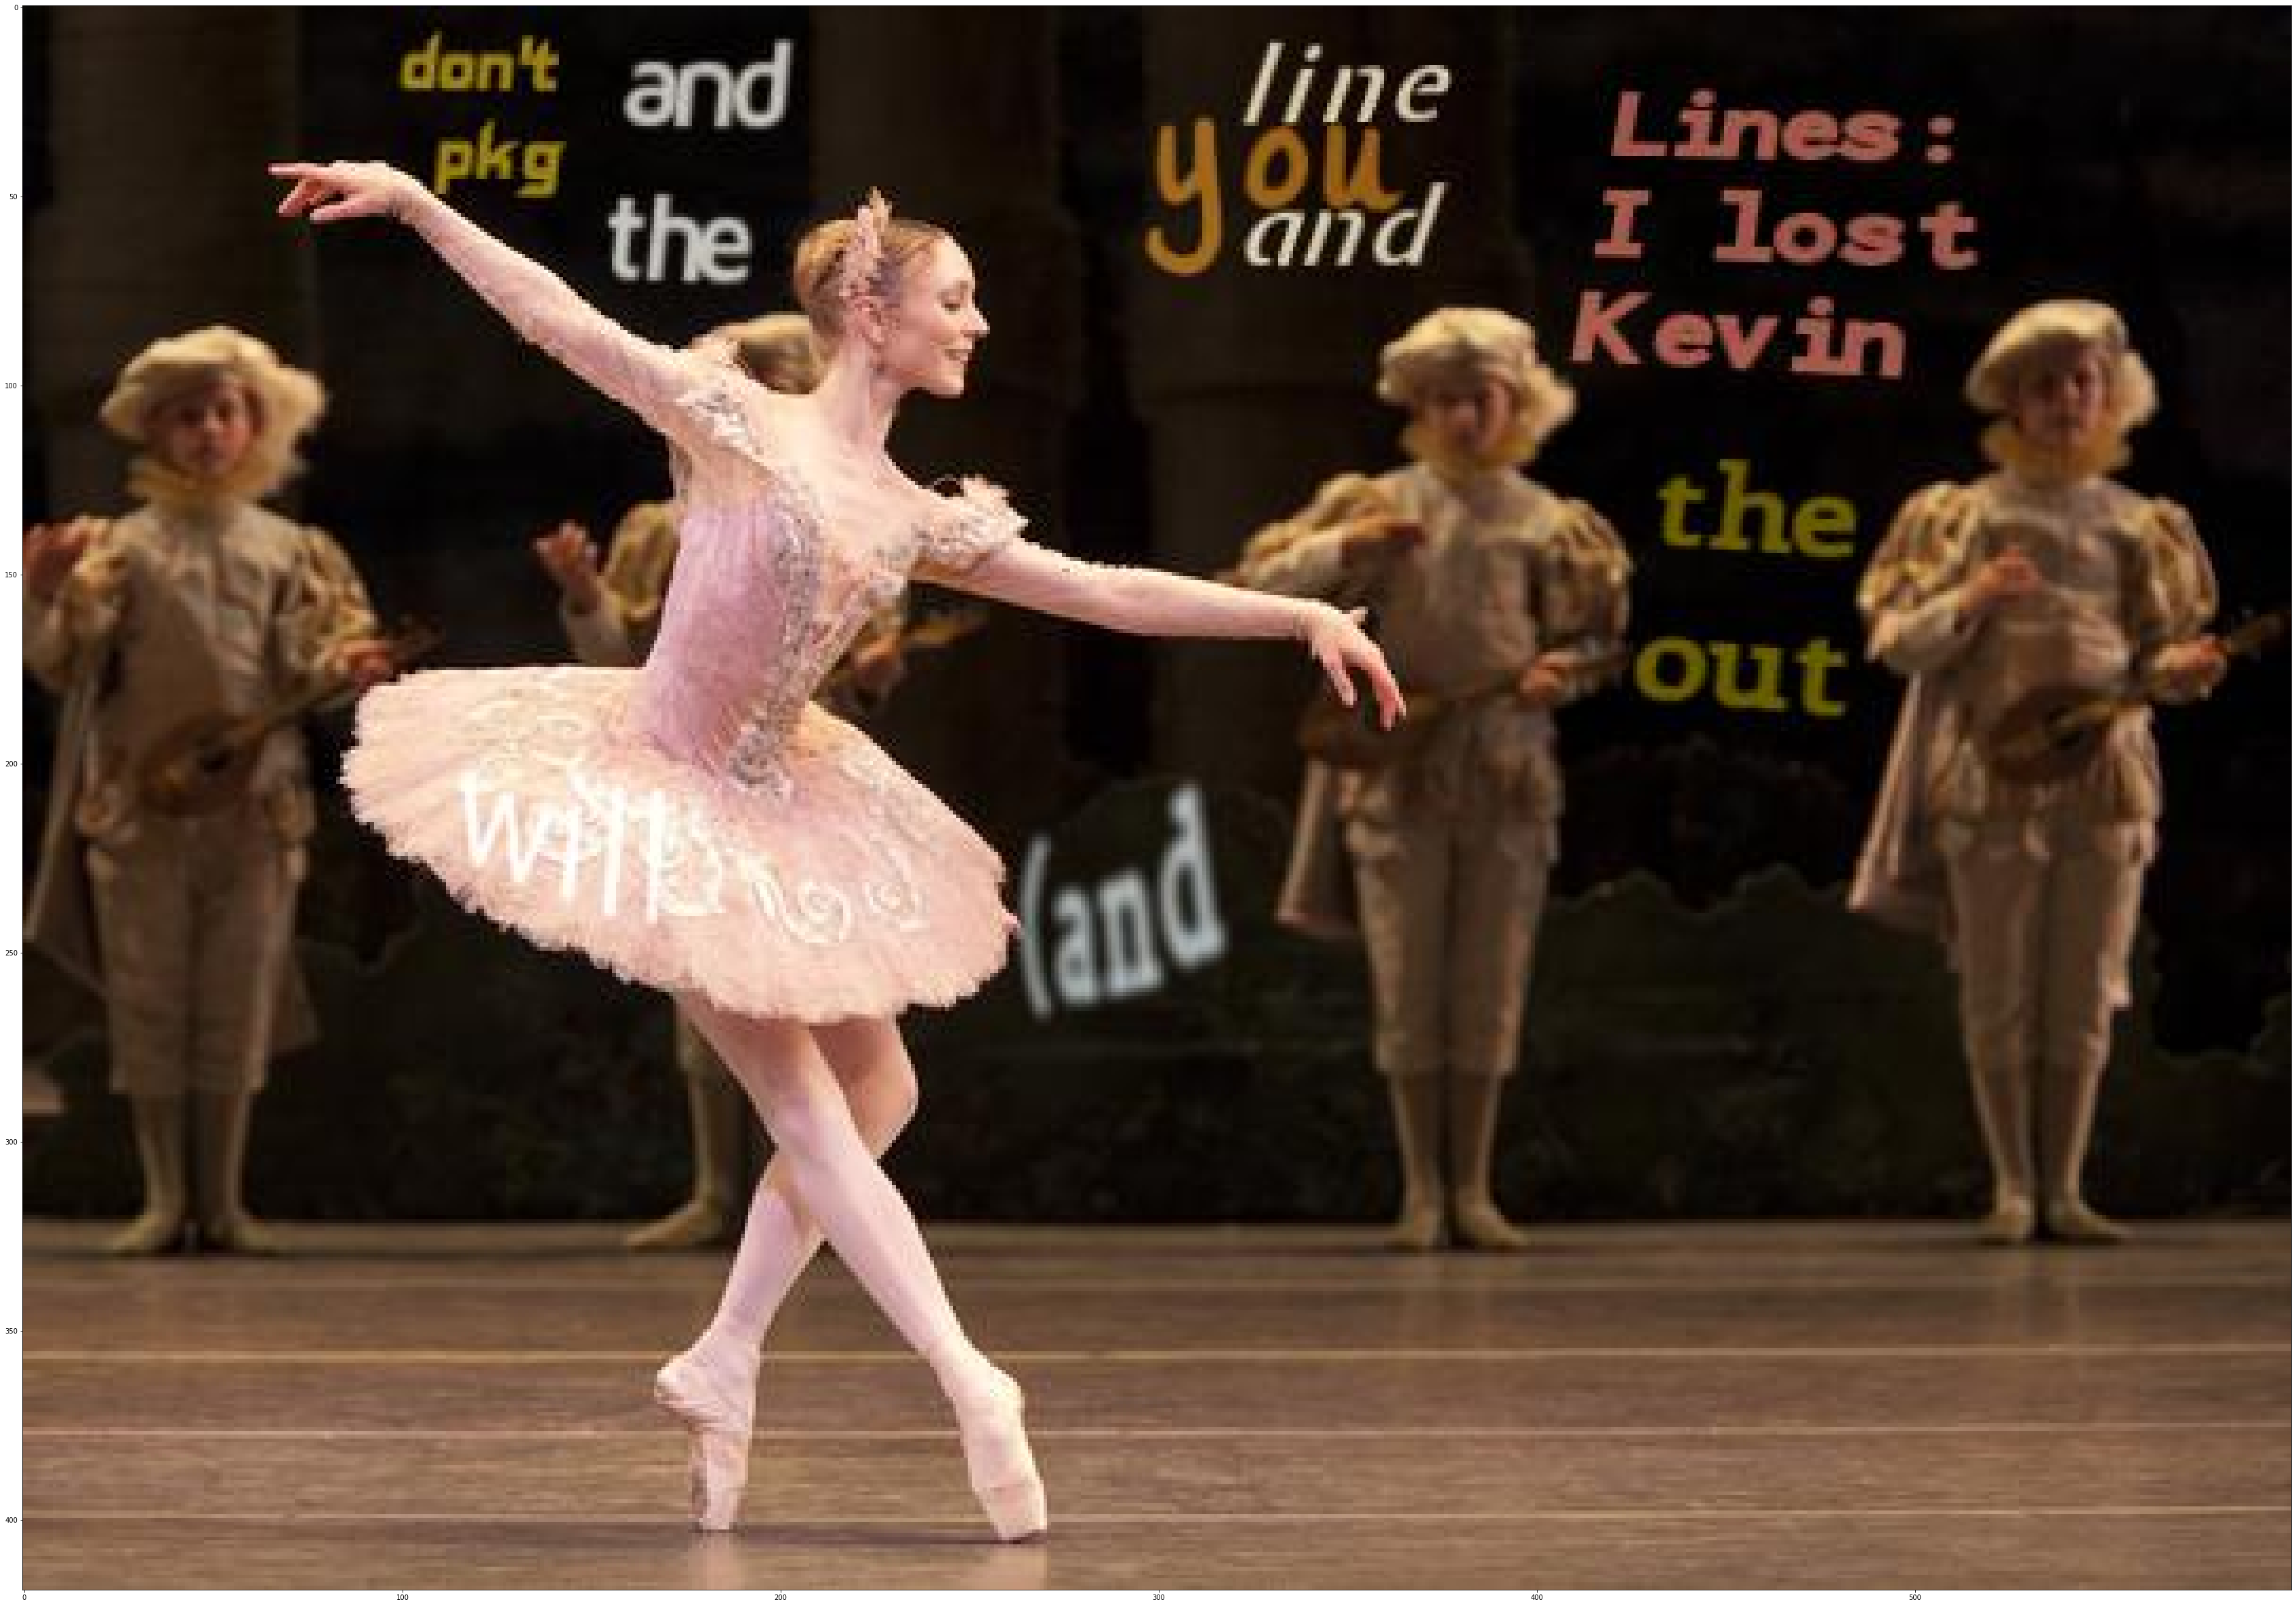

In [54]:
img_dir_path ='/data/data/synthtext/SynthText/'
img_file_path = img_dir_path+str(temp['imnames'][0][0])[2:-2]

image = cv2.imread(img_file_path)

print(img_file_path)
plt.figure(figsize = (60,60))
# plt.imshow(image)

## rgb = bgr[...,::-1].copy()
plt.imshow(image[...,::-1])